In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightly-1.2.17-py3-none-any.whl (442 kB)
  Using cached hydra_core-1.2.0-py3-none-any.whl (151 kB)
  Using cached lightly_utils-0.0.2-py3-none-any.whl (6.4 kB)


In [3]:
import torch
from torch import nn
import torchvision
import copy

from lightly.data import LightlyDataset
from lightly.data import SimCLRCollateFunction
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum
import lightly
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image



/usr/local/lib/python3.7/dist-packages/lightly/cli/train_cli.py:145: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")
/usr/local/lib/python3.7/dist-packages/lightly/cli/embed_cli.py:97: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/usr/local/lib/python3.7/dist-packages/lightly/cli/upload_cli.py:167: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/usr/local/lib/python3.7/dist-packages/lightly/cli/lightly_cli.py:70: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability versio

In [4]:
class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(512, 1024, 256)
        self.prediction_head = BYOLProjectionHead(256, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

In [5]:
path_to_data = '/content/drive/MyDrive/RHEED'
path_to_test = '/content/drive/MyDrive/Train'

In [6]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BYOL(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [8]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 50
input_size = 32
num_ftrs = 32


In [9]:


collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    gaussian_blur=0.
)

# We create a torchvision transformation for embedding the dataset after
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)
dataset_test2 = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

dataloader_test2 = torch.utils.data.DataLoader(
    dataset_test2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BYOL(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [11]:
dataset = dataset_train_simclr

In [12]:
'''
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

print("Starting Training")
for epoch in range(max_epochs):
    total_loss = 0
    for (x0, x1), _, _ in dataloader_train_simclr:
        update_momentum(model.backbone, model.backbone_momentum, m=0.99)
        update_momentum(model.projection_head, model.projection_head_momentum, m=0.99)
        x0 = x0.to(device)
        x1 = x1.to(device)
        p0 = model(x0)
        z0 = model.forward_momentum(x0)
        p1 = model(x1)
        z1 = model.forward_momentum(x1)
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader_train_simclr)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    '''

'\ncriterion = NegativeCosineSimilarity()\noptimizer = torch.optim.SGD(model.parameters(), lr=0.06)\n\nprint("Starting Training")\nfor epoch in range(max_epochs):\n    total_loss = 0\n    for (x0, x1), _, _ in dataloader_train_simclr:\n        update_momentum(model.backbone, model.backbone_momentum, m=0.99)\n        update_momentum(model.projection_head, model.projection_head_momentum, m=0.99)\n        x0 = x0.to(device)\n        x1 = x1.to(device)\n        p0 = model(x0)\n        z0 = model.forward_momentum(x0)\n        p1 = model(x1)\n        z1 = model.forward_momentum(x1)\n        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))\n        total_loss += loss.detach()\n        loss.backward()\n        optimizer.step()\n        optimizer.zero_grad()\n    avg_loss = total_loss / len(dataloader_train_simclr)\n    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")\n    '

In [13]:
#torch.save(model, '/content/drive/MyDrive/model_BYOL_'+str(max_epochs)+'gauss' +'.pt')
model = torch.load('/content/drive/MyDrive/model_BYOL_'+str(max_epochs)+'gauss'+'.pt')

In [14]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to('cuda')
            emb = model.backbone(img).cpu().flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [15]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=9, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            fig.set_size_inches(40,50)

            # let's disable the axis
            plt.axis('off')

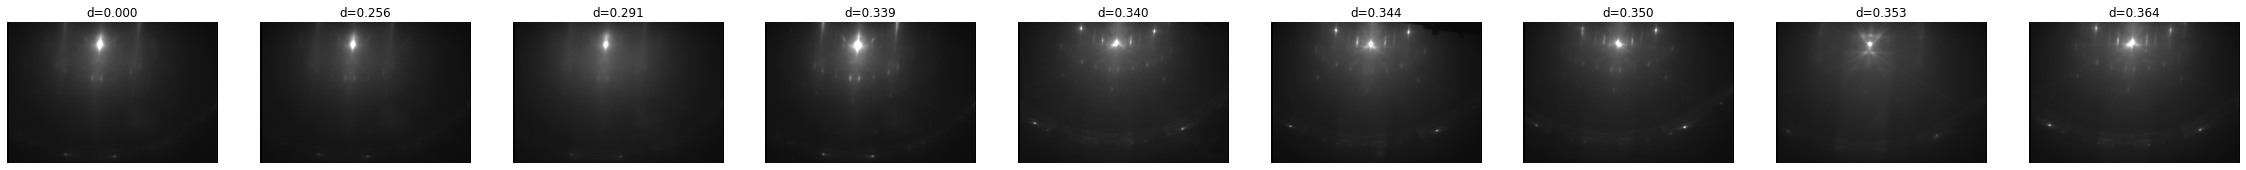

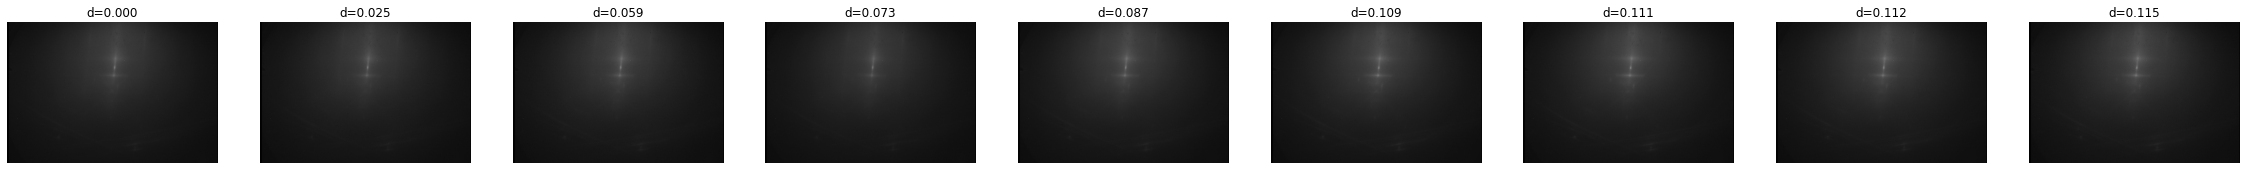

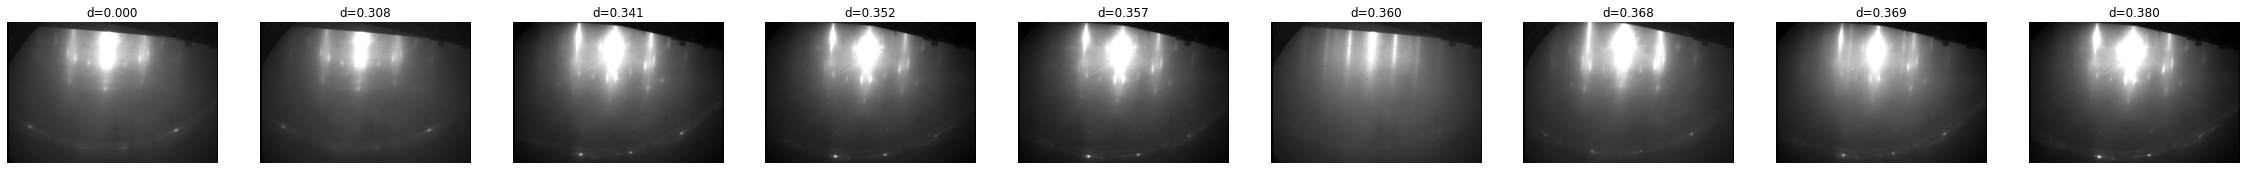

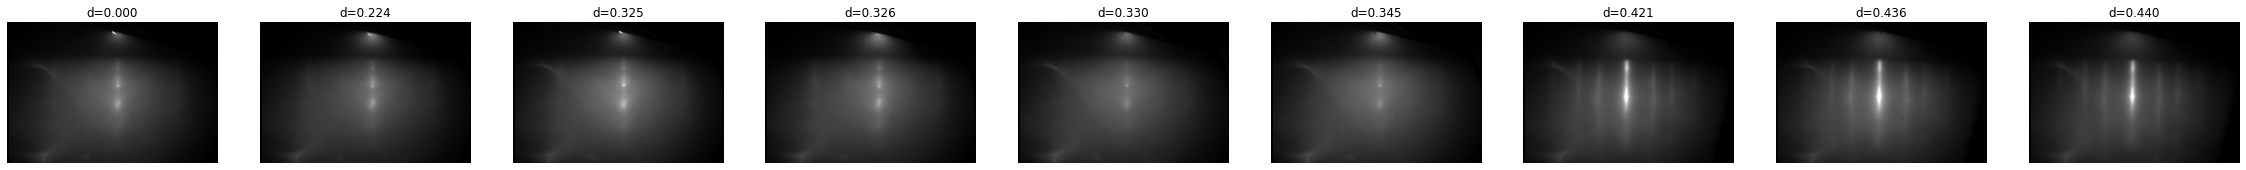

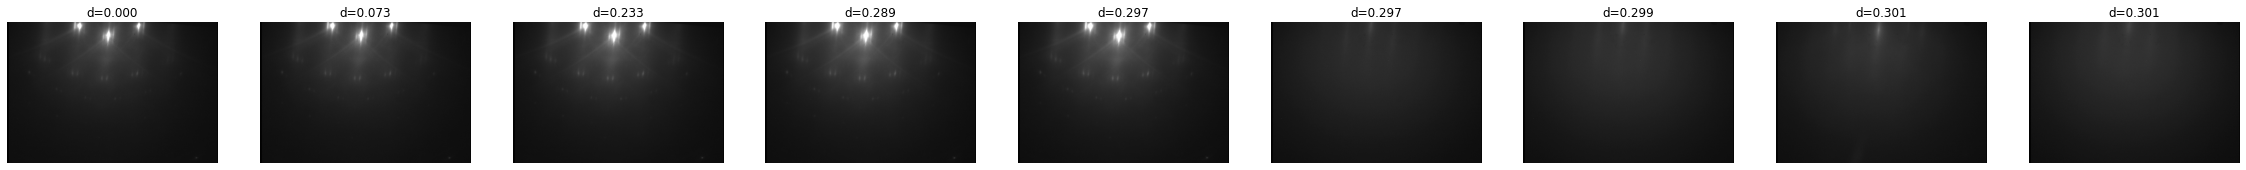

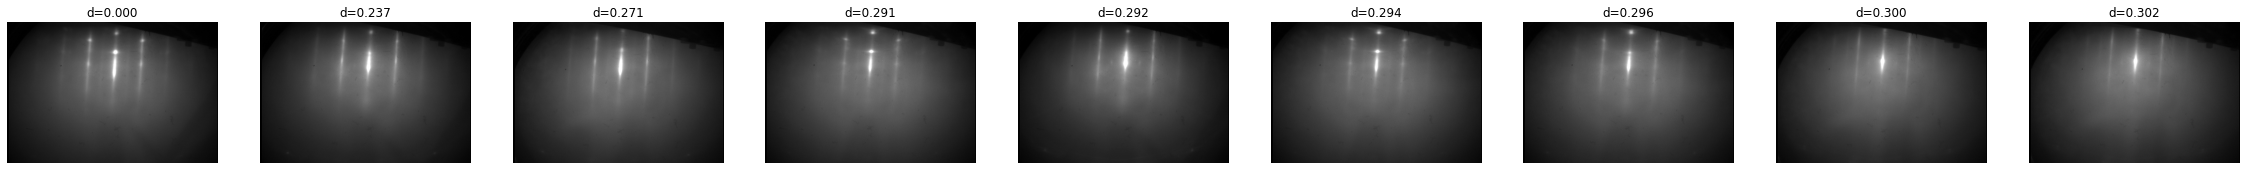

In [16]:
plot_knn_examples(embeddings, filenames)


In [17]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [18]:
import pandas as pd
import seaborn as sns

In [19]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [20]:
df_li = pd.read_csv("/content/drive/MyDrive/Samples/idx_sample.csv")
shown_list = df_li['0']
shown_lists = shown_list.tolist()
type(shown_lists)

list

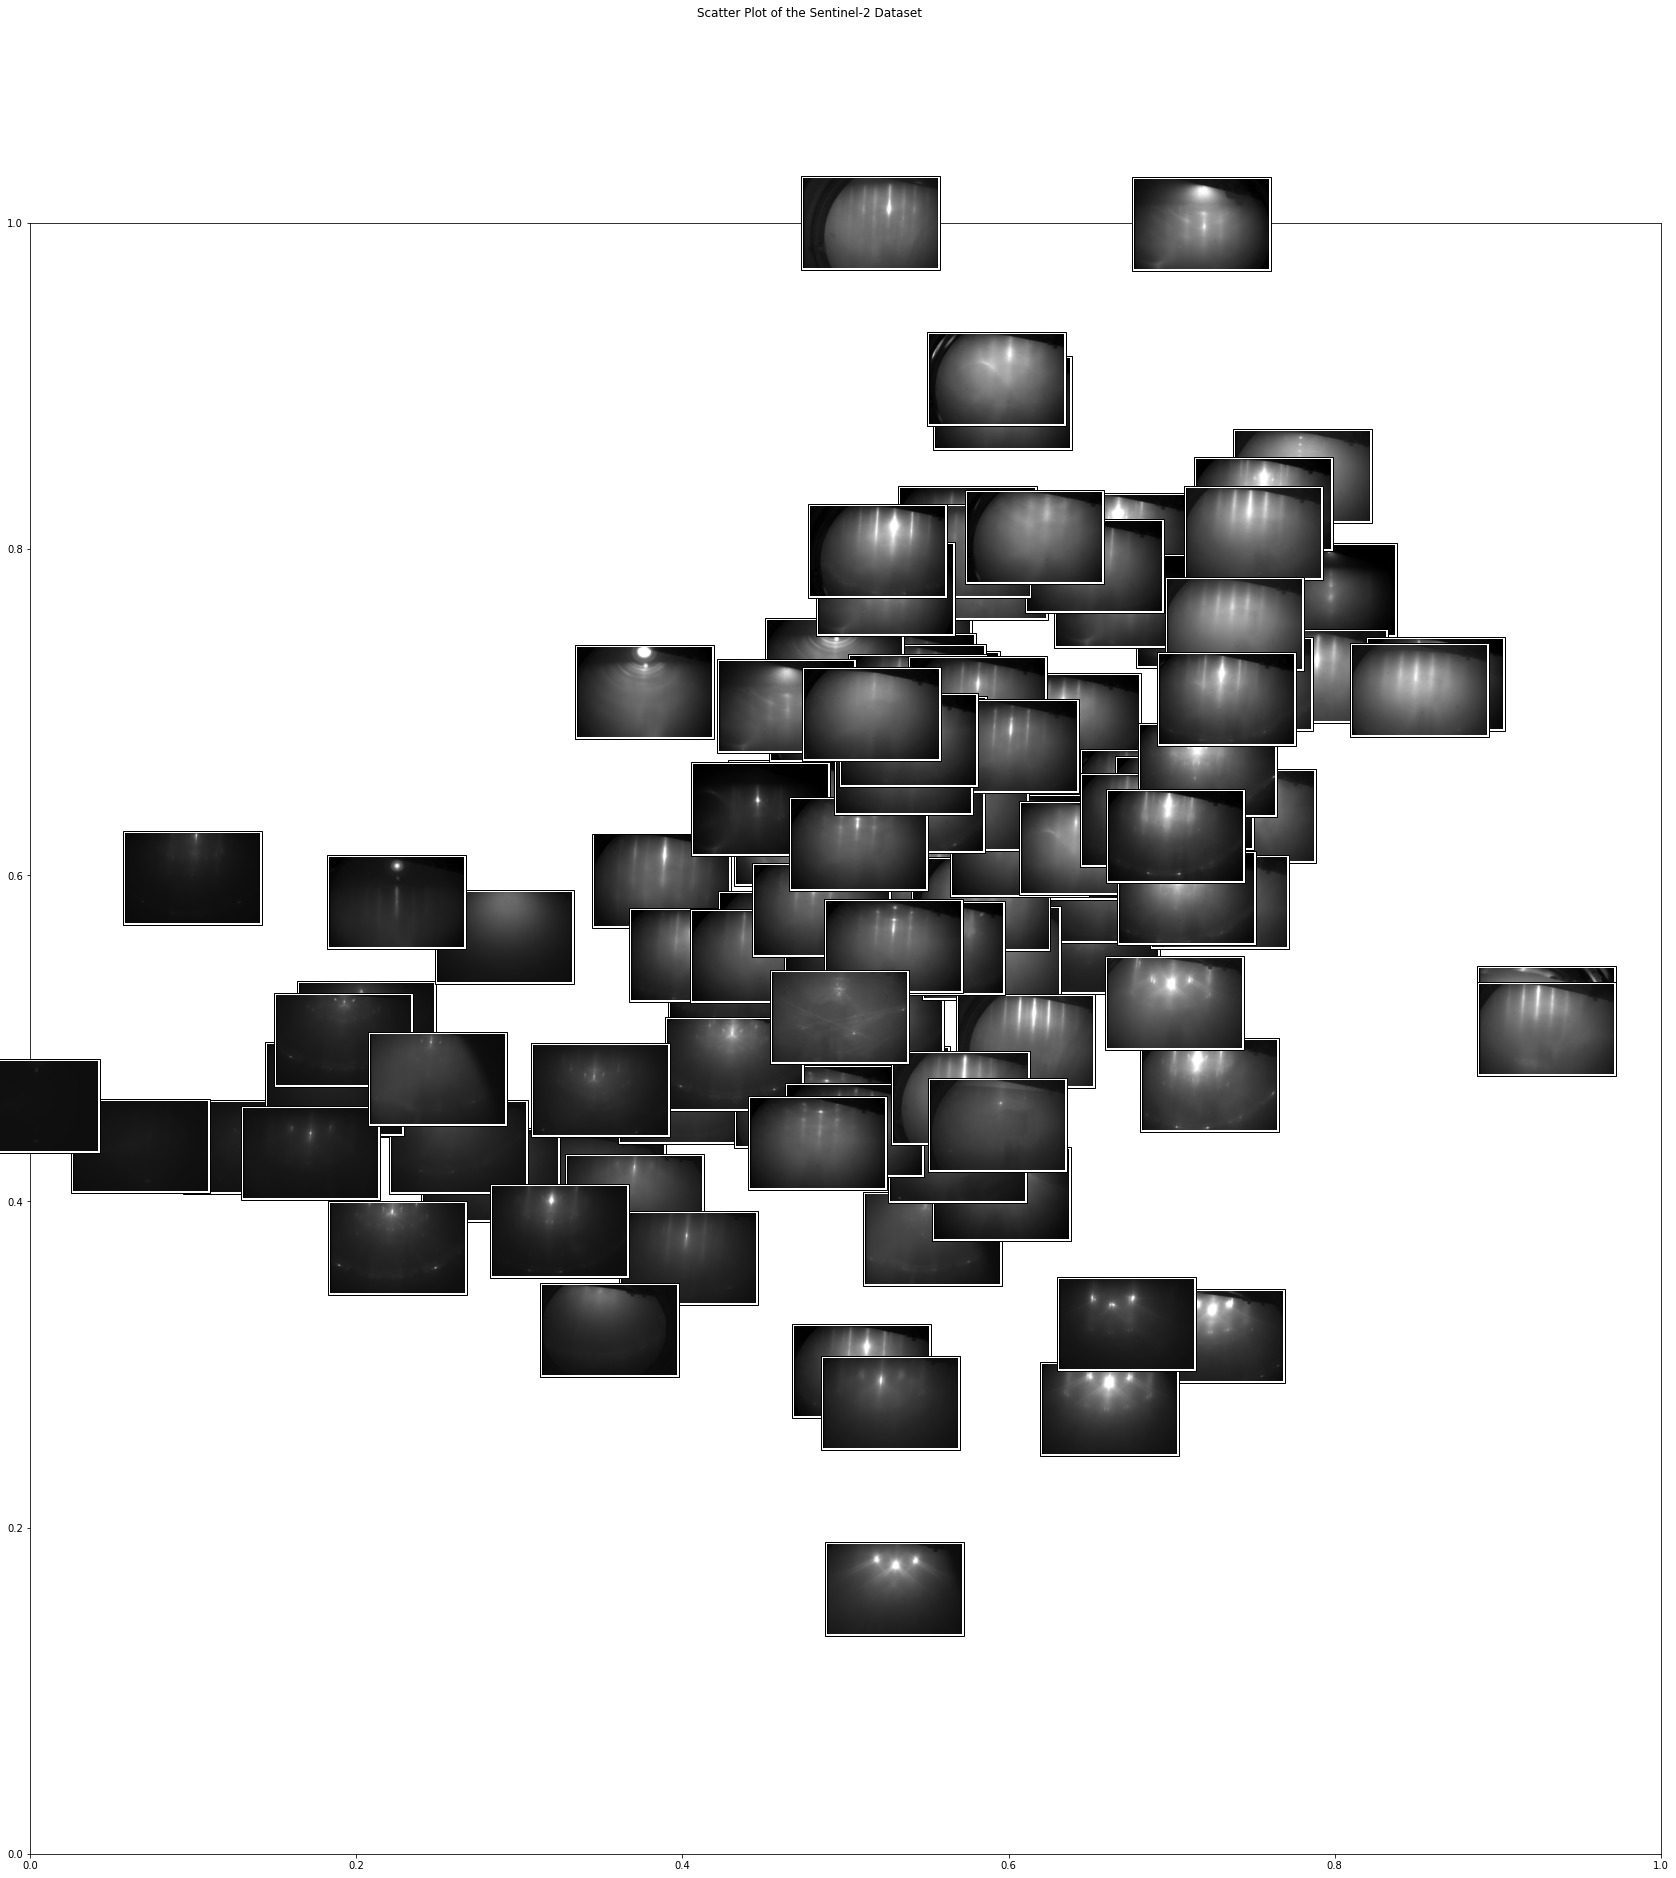

In [21]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot

    fig = plt.figure()
    fig.set_size_inches(40,30)

    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)

    '''
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.seed(0)
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        #if np.min(dist) < 2e-3:
        #    continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)
    print(shown_images_idx)
    arr1 = np.array(shown_images_idx)
#    np.save('/content/drive/MyDrive/idx.csv', arr1) 

    # plot image overlays
    filenames_solution=[]

'''
    shown_images_idx = shown_lists
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 15.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)
 #       filenames_solution.append(filenames[idx])
#    print(filenames_solution)
#    arr2 = np.array(filenames_solution)
#   np.save('/content/drive/MyDrive/fname.csv', arr2) 




    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
#    plt.savefig('/content/drive/MyDrive/Figures/' + 'savefig_default2'+str(max_epochs)+'vr,rr,crop'+'.png')

# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [22]:
import seaborn as sns
import pandas as pd

In [54]:
df = pd.DataFrame(embeddings_2d, columns=['x','y'])
non=[]
non = [i for i in range(df.shape[0])]
droper=[]
droper = [x for x in non if x not in shown_lists]
df = df.drop(droper)
df = df.reset_index()
df

,index,x,y
0,10,0.434017,0.538228
1,18,0.555091,0.555314
2,33,0.592674,0.904237
3,40,0.616207,0.807583
4,41,0.582886,0.582337
...,...,...,...
127,2624,0.568482,0.702572
128,2629,0.495421,0.698151
129,2653,0.387028,0.596284
130,2663,0.596418,0.889868


In [24]:
df2 = pd.read_csv('/content/drive/MyDrive/Samples/fname_sample - fname_sample.csv')
df2 = df2.drop(['설명: 1x1 1, 2x2 2, 3D 3, poly 4, 그래핀합성전 5, 그래핀6, 그래핀-1x1 7, 1x1 broad 8, flat substrate 9, dot 10, Broad 11'],axis=1)
df2

,Fname,Label,1순서
0,0103_15시43분_Video_1.jpg,1,25
1,0105_23시09분_Video700도어닐후.jpg,7,101
2,0109_19시10분_Video증착4분.jpg,3,64
3,0109_19시38분_Video증착완료.jpg,3,99
4,0109_20시15분_Video600어닐후.jpg,3,85
...,...,...,...
127,1213_18시11분_Video600도 어닐링후 250도 부ᄀ...,7,79
128,1213_19시10분_VideoSe처리2분.jpg,10,39
129,1214_19시02분_Video600도어닐후250도.jpg,8,5
130,1216_15시43분_Video.jpg,7,35


In [25]:
df2_s = df2

In [26]:
df2 = df2.sort_values(by=['1순서'], ascending=[True])
df2['Label'] = df2_s['Label']
df2 = df2.reset_index()
df2= df2.drop(['index'],axis=1)
df2

,Fname,Label,1순서
0,0416_14시32분_Video05.jpg,1,2
1,0707_20시28분_Video1-00.jpg,7,3
2,1101_13시34분_Video5.jpg,7,4
3,1214_19시02분_Video600도어닐후250도.jpg,8,5
4,1025_09시19분_Video 30m anneal.jpg,11,6
...,...,...,...
127,1014_21시55분_Video.jpg,9,129
128,1010_16시48분_Video.jpg,11,130
129,0126_17시52분_Video17분.jpg,7,131
130,0425_22시19분_Video07.jpg,1,132


In [58]:
df['Label'] = df2['Label']
df

,index,x,y,Label
0,10,0.434017,0.538228,1
1,18,0.555091,0.555314,7
2,33,0.592674,0.904237,7
3,40,0.616207,0.807583,8
4,41,0.582886,0.582337,11
...,...,...,...,...
127,2624,0.568482,0.702572,9
128,2629,0.495421,0.698151,11
129,2653,0.387028,0.596284,7
130,2663,0.596418,0.889868,1


In [38]:
D = [1,2,5,6,7,8]
E = [3,4,9,10]
F = [11]

In [52]:
df.iloc[i][4]

'A'

In [57]:
df['Label'][0]

1

In [60]:
df

,index,x,y,Label
0,10,0.434017,0.538228,A
1,18,0.555091,0.555314,A
2,33,0.592674,0.904237,A
3,40,0.616207,0.807583,A
4,41,0.582886,0.582337,C
...,...,...,...,...
127,2624,0.568482,0.702572,B
128,2629,0.495421,0.698151,C
129,2653,0.387028,0.596284,A
130,2663,0.596418,0.889868,A


In [62]:

D = [1,2,5,6,7,8]
E = [3,4,9,10]
F = [11]
for i in range(0,132):
  if df.iloc[i][3] in D:
    df['Label'][i]= 'A'
  if df.iloc[i][3] in E:
    df['Label'][i]='B'
  if df.iloc[i][3] in F:
    df['Label'][i]='C'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


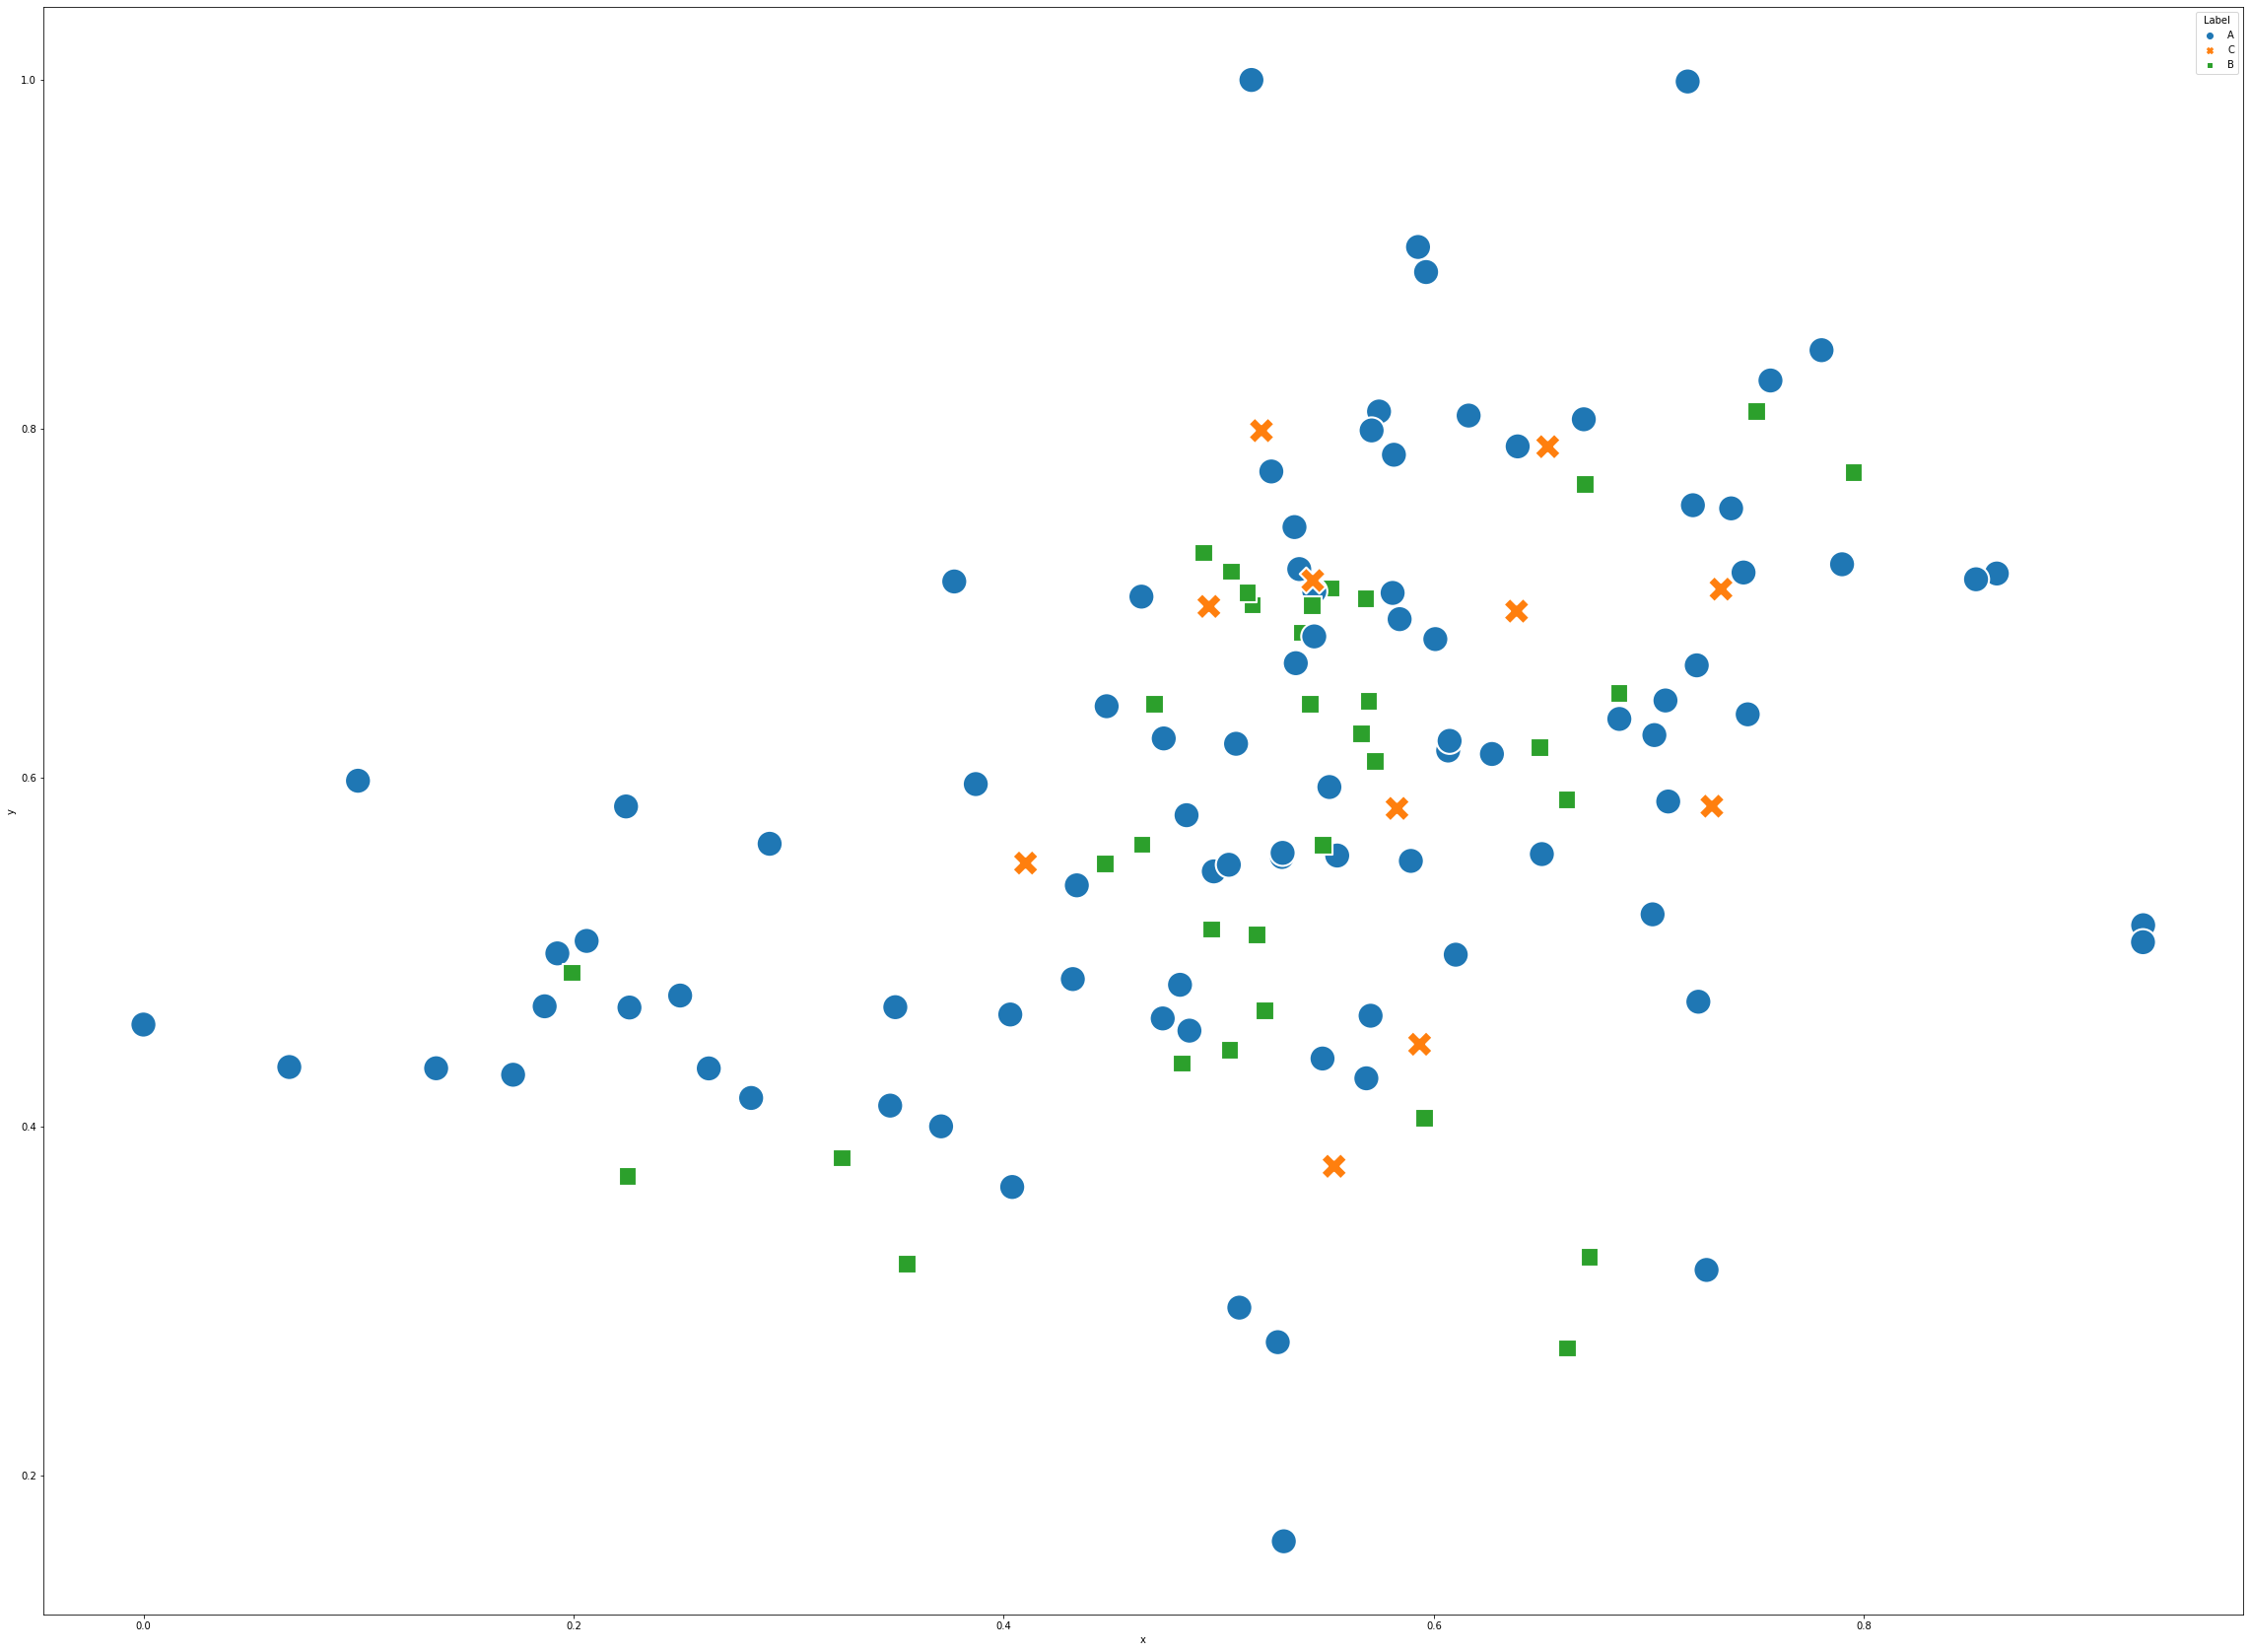

In [64]:
fig = plt.figure()

ax = sns.scatterplot(x="x",y="y",data=df,hue='Label',style = "Label",s=700)

fig.set_size_inches(40,30)


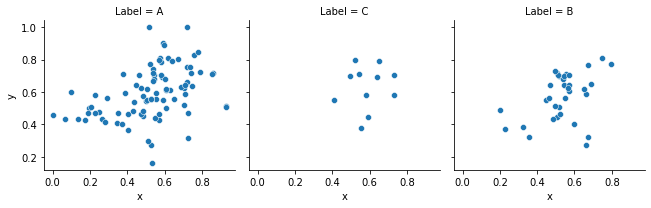

In [65]:
grid = sns.FacetGrid(data=df, col = "Label",col_wrap=4)
grid.map(sns.scatterplot, "x", "y")

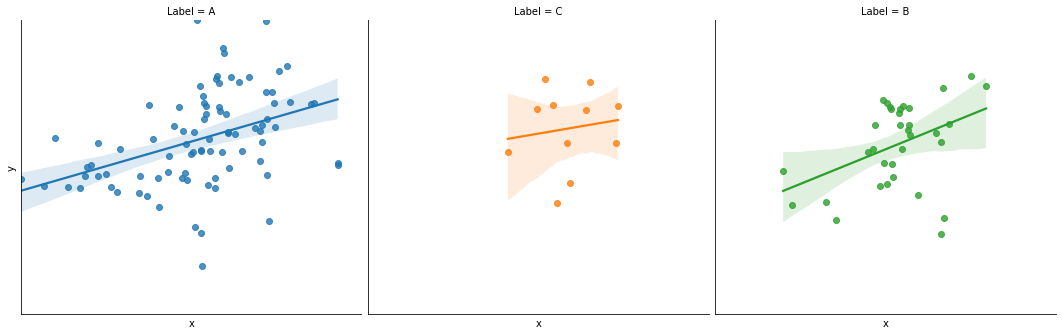

In [66]:
g = sns.lmplot(x="x", y="y", col="Label", hue="Label",
               data=df, col_wrap=4)
g = (g.set_axis_labels()
      .set(xlim=(0, 1), ylim=(0, 1),
           xticks=[10, 30, 50], yticks=[2, 6, 10])
      .fig.subplots_adjust(wspace=.02))

In [69]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')